In [457]:
from os import rename

# 라이브러리
import numpy as np
import pandas as pd
import datetime
import fsspec
import seaborn as sns
from IPython.lib.clipboard import osx_clipboard_get
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
from time import time
import os
from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn import model_selection
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from pandas import DataFrame
import xgboost as xgb
from prophet import Prophet
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm


In [458]:
# import dataset

store = pd.read_csv("C:/Users/wkdal/DREW_PY/2025/Personal_Projects/Rossmann Store Sales Prediction/store.csv")
train = pd.read_csv("C:/Users/wkdal/DREW_PY/2025/Personal_Projects/Rossmann Store Sales Prediction/train.csv")
test = pd.read_csv("C:/Users/wkdal/DREW_PY/2025/Personal_Projects/Rossmann Store Sales Prediction/train.csv")

In [459]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [460]:
store = store.rename(columns = {
    "Store" : "매장ID",
    "StoreType" : "매장유형",
    "Assortment" : "매장유형구분",
    "CompetitionDistance" : "가장가까운_경쟁매장까지거리",
    "CompetitionOpenSinceMonth" : "경쟁매장개점(월)",
    "CompetitionOpenSinceYear": "경쟁매장개점(연도)",
    "Promo2" : "상시프로모션고객참여여부",
    "Promo2SinceWeek" : "프로모션참여(주)",
    "Promo2SinceYear" : "프로모션참여(연도)",
    "PromoInterval" : "프로모션시작(월)"

})

In [461]:
store.head()

,매장ID,매장유형,매장유형구분,가장가까운_경쟁매장까지거리,경쟁매장개점(월),경쟁매장개점(연도),상시프로모션고객참여여부,프로모션참여(주),프로모션참여(연도),프로모션시작(월)
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [462]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [463]:
train = train.rename(columns={
    "Store" : "매장ID",
    "DayOfWeek" : "날짜(요일)",
    "Date" : "매출일",
    "Sales" : "예상매출액",
    "Customers" : "방문고객수",
    "Open" : "매장영업여부",
    "Promo" : "프로모션시행여부",
    "StateHoliday" : "공휴일정보",
    "SchoolHoliday" : "공립학교휴교여부"
})

In [464]:
train.head()

,매장ID,날짜(요일),매출일,예상매출액,방문고객수,매장영업여부,프로모션시행여부,공휴일정보,공립학교휴교여부
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [465]:
test.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [466]:
test = test.rename(columns={
    "Store" : "매장ID",
    "DayOfWeek" : "날짜(요일)",
    "Date" : "매출일",
    "Sales" : "예상매출액",
    "Customers" : "방문고객수",
    "Open" : "매장영업여부",
    "Promo" : "(1차)프로모션시행여부",
    "StateHoliday" : "공휴일정보",
    "SchoolHoliday" : "공립학교휴교여부"
})

In [467]:
test.head()

,매장ID,날짜(요일),매출일,예상매출액,방문고객수,매장영업여부,(1차)프로모션시행여부,공휴일정보,공립학교휴교여부
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


# 1. Explamatory Data Analysis(EDA)

### 1.1. 트렌드 & 계절성


#### 소주제 : 매출이 월별 1차 프로모션 시행 여부, 상시 프로모션 시행 여부, 그리고 연도에 따라 어떻게 달라지는가?

In [468]:
train.shape

(1017209, 9)

In [469]:
train.sort_values(by="매출일")

,매장ID,날짜(요일),매출일,예상매출액,방문고객수,매장영업여부,프로모션시행여부,공휴일정보,공립학교휴교여부
1017208,1115,2,2013-01-01,0,0,0,0,a,1
1016473,379,2,2013-01-01,0,0,0,0,a,1
1016472,378,2,2013-01-01,0,0,0,0,a,1
1016471,377,2,2013-01-01,0,0,0,0,a,1
1016470,376,2,2013-01-01,0,0,0,0,a,1
...,...,...,...,...,...,...,...,...,...
745,746,5,2015-07-31,9082,638,1,1,0,1
746,747,5,2015-07-31,10708,826,1,1,0,1
747,748,5,2015-07-31,7481,578,1,1,0,1
741,742,5,2015-07-31,10460,1016,1,1,0,1


In [470]:
train['매출일'] = pd.to_datetime(train['매출일'])

In [471]:
train = train.set_index("매출일")

In [472]:
train.head()

,매장ID,날짜(요일),예상매출액,방문고객수,매장영업여부,프로모션시행여부,공휴일정보,공립학교휴교여부
매출일,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


- train 데이터는 100만개의 관측치(행)과 9개의 필드(열)가 있다.
- train 데이터의 매출 날짜는 2013 ~ 2015년까지 있다.
- 매출일을 문자에서 날짜로 변경하고, 인덱스로 변경

"날짜컬럼을 연도,월,일,주 컬럼으로 분리하시오."

In [473]:
train['연도'] = train.index.isocalendar().year
train['월'] = train.index.month
train['일'] = train.index.day
train['연도의N번째주'] = train.index.isocalendar().week

train['고객당평균매출'] = train['예상매출액'] / train['방문고객수']


In [474]:
train.head()

,매장ID,날짜(요일),예상매출액,방문고객수,매장영업여부,프로모션시행여부,공휴일정보,공립학교휴교여부,연도,월,일,연도의N번째주,고객당평균매출
매출일,,,,,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1,2015,7,31,31,9.482883
2015-07-31,2,5,6064,625,1,1,0,1,2015,7,31,31,9.702400
2015-07-31,3,5,8314,821,1,1,0,1,2015,7,31,31,10.126675
2015-07-31,4,5,13995,1498,1,1,0,1,2015,7,31,31,9.342457
2015-07-31,5,5,4822,559,1,1,0,1,2015,7,31,31,8.626118


"매장이 닫혀 있는 날짜의 데이터를 확인하시오"

In [475]:
train_store_closed = train[(train.매장영업여부 == 0)]
train_store_closed

,매장ID,날짜(요일),예상매출액,방문고객수,매장영업여부,프로모션시행여부,공휴일정보,공립학교휴교여부,연도,월,일,연도의N번째주,고객당평균매출
매출일,,,,,,,,,,,,,
2015-07-31,292,5,0,0,0,1,0,1,2015,7,31,31,NaN
2015-07-31,876,5,0,0,0,1,0,1,2015,7,31,31,NaN
2015-07-30,292,4,0,0,0,1,0,1,2015,7,30,31,NaN
2015-07-30,876,4,0,0,0,1,0,1,2015,7,30,31,NaN
2015-07-29,292,3,0,0,0,1,0,1,2015,7,29,31,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-01-01,1111,2,0,0,0,0,a,1,2013,1,1,1,NaN
2013-01-01,1112,2,0,0,0,0,a,1,2013,1,1,1,NaN
2013-01-01,1113,2,0,0,0,0,a,1,2013,1,1,1,NaN


array([[<Axes: title={'center': '날짜(요일)'}>]], dtype=object)

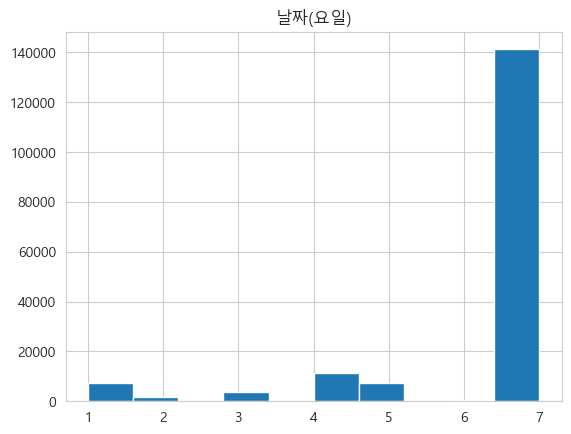

In [476]:
plt.rc('font', family='Malgun Gothic')   # ← 윈도우 한글 폰트
plt.rc('axes', unicode_minus=False)      # 음수 기호 깨짐 방지
train_store_closed.hist('날짜(요일)')

- 7번째 요일은 일요일이며, 일요일은 대부분 영업하지 않음을 알 수 있다.

<Axes: xlabel='공휴일정보'>

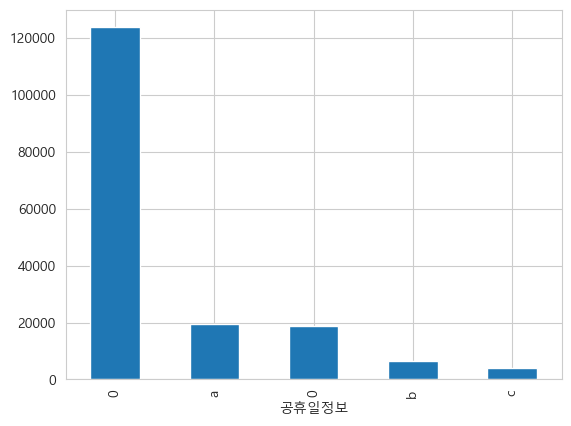

In [477]:
train_store_closed['공휴일정보'].value_counts().plot(kind='bar')

- a = 공휴일, 20000건 , b = 부활절, c = 크리스마스에 매장을 닫는다.

In [478]:
train.isnull()

,매장ID,날짜(요일),예상매출액,방문고객수,매장영업여부,프로모션시행여부,공휴일정보,공립학교휴교여부,연도,월,일,연도의N번째주,고객당평균매출
매출일,,,,,,,,,,,,,
2015-07-31,False,False,False,False,False,False,False,False,False,False,False,False,False
2015-07-31,False,False,False,False,False,False,False,False,False,False,False,False,False
2015-07-31,False,False,False,False,False,False,False,False,False,False,False,False,False
2015-07-31,False,False,False,False,False,False,False,False,False,False,False,False,False
2015-07-31,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-01-01,False,False,False,False,False,False,False,False,False,False,False,False,True
2013-01-01,False,False,False,False,False,False,False,False,False,False,False,False,True
2013-01-01,False,False,False,False,False,False,False,False,False,False,False,False,True


In [479]:
train.isnull().sum()

매장ID             0
날짜(요일)           0
예상매출액            0
방문고객수            0
매장영업여부           0
프로모션시행여부         0
공휴일정보            0
공립학교휴교여부         0
연도               0
월                0
일                0
연도의N번째주          0
고객당평균매출     172869
dtype: int64

In [480]:
train[(train.매장영업여부 == 0)].shape[0]

172817

- 매장의 휴업(0)은 172817번 이다.

In [481]:
train[(train.매장영업여부 == 1)].shape[0]

844392

- 매장 영업(1)은 844392이다.

#### "매장 관련 데이터 처리하기"

In [482]:
store.head()

,매장ID,매장유형,매장유형구분,가장가까운_경쟁매장까지거리,경쟁매장개점(월),경쟁매장개점(연도),상시프로모션고객참여여부,프로모션참여(주),프로모션참여(연도),프로모션시작(월)
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [483]:
store.isnull().sum()

매장ID                0
매장유형                0
매장유형구분              0
가장가까운_경쟁매장까지거리      3
경쟁매장개점(월)         354
경쟁매장개점(연도)        354
상시프로모션고객참여여부        0
프로모션참여(주)         544
프로모션참여(연도)        544
프로모션시작(월)         544
dtype: int64

#### "경쟁 매장까지의 거리가 비어있는 경우, 중앙값으로 넣어준다."

In [484]:
store['가장가까운_경쟁매장까지거리'].fillna(store['가장가까운_경쟁매장까지거리'].median(), inplace=True)

In [485]:
store.head()

,매장ID,매장유형,매장유형구분,가장가까운_경쟁매장까지거리,경쟁매장개점(월),경쟁매장개점(연도),상시프로모션고객참여여부,프로모션참여(주),프로모션참여(연도),프로모션시작(월)
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [486]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   매장ID            1115 non-null   int64  
 1   매장유형            1115 non-null   object 
 2   매장유형구분          1115 non-null   object 
 3   가장가까운_경쟁매장까지거리  1115 non-null   float64
 4   경쟁매장개점(월)       761 non-null    float64
 5   경쟁매장개점(연도)      761 non-null    float64
 6   상시프로모션고객참여여부    1115 non-null   int64  
 7   프로모션참여(주)       571 non-null    float64
 8   프로모션참여(연도)      571 non-null    float64
 9   프로모션시작(월)       571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [487]:
store.fillna(0,inplace=True)

In [488]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   매장ID            1115 non-null   int64  
 1   매장유형            1115 non-null   object 
 2   매장유형구분          1115 non-null   object 
 3   가장가까운_경쟁매장까지거리  1115 non-null   float64
 4   경쟁매장개점(월)       1115 non-null   float64
 5   경쟁매장개점(연도)      1115 non-null   float64
 6   상시프로모션고객참여여부    1115 non-null   int64  
 7   프로모션참여(주)       1115 non-null   float64
 8   프로모션참여(연도)      1115 non-null   float64
 9   프로모션시작(월)       1115 non-null   object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [489]:
store.isnull().sum()

매장ID              0
매장유형              0
매장유형구분            0
가장가까운_경쟁매장까지거리    0
경쟁매장개점(월)         0
경쟁매장개점(연도)        0
상시프로모션고객참여여부      0
프로모션참여(주)         0
프로모션참여(연도)        0
프로모션시작(월)         0
dtype: int64

In [490]:
store.isnull().sum().sum()

np.int64(0)

- 전체 결측치의 총 값은 0이다.

#### "테스트 데이터 처리하기"

In [491]:
test.head()

,매장ID,날짜(요일),매출일,예상매출액,방문고객수,매장영업여부,(1차)프로모션시행여부,공휴일정보,공립학교휴교여부
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [492]:
test.isnull().sum()

매장ID            0
날짜(요일)          0
매출일             0
예상매출액           0
방문고객수           0
매장영업여부          0
(1차)프로모션시행여부    0
공휴일정보           0
공립학교휴교여부        0
dtype: int64

In [493]:
test.isnull().sum().sum()

np.int64(0)

- 전체 결측치의 총 값은 0이다.

### store와 train을 병합한다.

In [494]:
train_store_joined = pd.merge(train,store, on='매장ID', how='inner')

In [495]:
train_store_joined.head()

,매장ID,날짜(요일),예상매출액,방문고객수,매장영업여부,프로모션시행여부,공휴일정보,공립학교휴교여부,연도,월,...,고객당평균매출,매장유형,매장유형구분,가장가까운_경쟁매장까지거리,경쟁매장개점(월),경쟁매장개점(연도),상시프로모션고객참여여부,프로모션참여(주),프로모션참여(연도),프로모션시작(월)
0,1,5,5263,555,1,1,0,1,2015,7,...,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,2,5,6064,625,1,1,0,1,2015,7,...,9.702400,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,8314,821,1,1,0,1,2015,7,...,10.126675,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,13995,1498,1,1,0,1,2015,7,...,9.342457,c,c,620.0,9.0,2009.0,0,0.0,0.0,0
4,5,5,4822,559,1,1,0,1,2015,7,...,8.626118,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0


In [496]:
train_store_joined.groupby('매장유형')[['방문고객수','예상매출액','고객당평균매출']].sum().sort_values('예상매출액', ascending = True)

,방문고객수,예상매출액,고객당평균매출
매장유형,,,
b,31465621,159231395,7.987612e+04
c,92129705,783221426,9.744876e+05
d,156904995,1765392943,2.918350e+06
a,363541434,3165334859,4.043129e+06


#### 매장이 문을 닫았거나, 매출액이 없는 행

In [497]:
train_store_joined[ (train_store_joined.매장영업여부 == 0) | (train_store_joined.예상매출액 == 0)  ]

,매장ID,날짜(요일),예상매출액,방문고객수,매장영업여부,프로모션시행여부,공휴일정보,공립학교휴교여부,연도,월,...,고객당평균매출,매장유형,매장유형구분,가장가까운_경쟁매장까지거리,경쟁매장개점(월),경쟁매장개점(연도),상시프로모션고객참여여부,프로모션참여(주),프로모션참여(연도),프로모션시작(월)
291,292,5,0,0,0,1,0,1,2015,7,...,NaN,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0
875,876,5,0,0,0,1,0,1,2015,7,...,NaN,a,a,21790.0,4.0,2005.0,1,18.0,2015.0,"Feb,May,Aug,Nov"
1406,292,4,0,0,0,1,0,1,2015,7,...,NaN,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0
1990,876,4,0,0,0,1,0,1,2015,7,...,NaN,a,a,21790.0,4.0,2005.0,1,18.0,2015.0,"Feb,May,Aug,Nov"
2521,292,3,0,0,0,1,0,1,2015,7,...,NaN,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,0,0,0,0,a,1,2013,1,...,NaN,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1017205,1112,2,0,0,0,0,a,1,2013,1,...,NaN,c,c,1880.0,4.0,2006.0,0,0.0,0.0,0
1017206,1113,2,0,0,0,0,a,1,2013,1,...,NaN,a,c,9260.0,0.0,0.0,0,0.0,0.0,0
1017207,1114,2,0,0,0,0,a,1,2013,1,...,NaN,a,c,870.0,0.0,0.0,0,0.0,0.0,0


172,871개의 매장이 문을 닫았으며, 예상매출액이 0이다.

In [498]:
# ~(조건) : 매장이 닫힌 것이 아닌 행, 매장이 열린 행

train_store_joined_open = train_store_joined[~((train_store_joined.매장영업여부 ==0) | (train_store_joined.예상매출액==0))]
train_store_joined_open

,매장ID,날짜(요일),예상매출액,방문고객수,매장영업여부,프로모션시행여부,공휴일정보,공립학교휴교여부,연도,월,...,고객당평균매출,매장유형,매장유형구분,가장가까운_경쟁매장까지거리,경쟁매장개점(월),경쟁매장개점(연도),상시프로모션고객참여여부,프로모션참여(주),프로모션참여(연도),프로모션시작(월)
0,1,5,5263,555,1,1,0,1,2015,7,...,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,2,5,6064,625,1,1,0,1,2015,7,...,9.702400,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,8314,821,1,1,0,1,2015,7,...,10.126675,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,13995,1498,1,1,0,1,2015,7,...,9.342457,c,c,620.0,9.0,2009.0,0,0.0,0.0,0
4,5,5,4822,559,1,1,0,1,2015,7,...,8.626118,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,682,2,3375,566,1,0,a,1,2013,1,...,5.962898,b,a,150.0,9.0,2006.0,0,0.0,0.0,0
1016827,733,2,10765,2377,1,0,a,1,2013,1,...,4.528818,b,b,860.0,10.0,1999.0,0,0.0,0.0,0
1016863,769,2,5035,1248,1,0,a,1,2013,1,...,4.034455,b,b,840.0,0.0,0.0,1,48.0,2012.0,"Jan,Apr,Jul,Oct"
1017042,948,2,4491,1039,1,0,a,1,2013,1,...,4.322425,b,b,1430.0,0.0,0.0,0,0.0,0.0,0


### Correlation Analysis

두 변수간의 선형 관계가 얼마나 강한지 측정 (상관 계수)

(a가 증가하면 b도 증가하는가? 함께 움직이는 정도를 보임)

In [500]:
train_store_joined.head()

,매장ID,날짜(요일),예상매출액,방문고객수,매장영업여부,프로모션시행여부,공휴일정보,공립학교휴교여부,연도,월,...,고객당평균매출,매장유형,매장유형구분,가장가까운_경쟁매장까지거리,경쟁매장개점(월),경쟁매장개점(연도),상시프로모션고객참여여부,프로모션참여(주),프로모션참여(연도),프로모션시작(월)
0,1,5,5263,555,1,1,0,1,2015,7,...,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,2,5,6064,625,1,1,0,1,2015,7,...,9.702400,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,8314,821,1,1,0,1,2015,7,...,10.126675,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,13995,1498,1,1,0,1,2015,7,...,9.342457,c,c,620.0,9.0,2009.0,0,0.0,0.0,0
4,5,5,4822,559,1,1,0,1,2015,7,...,8.626118,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0


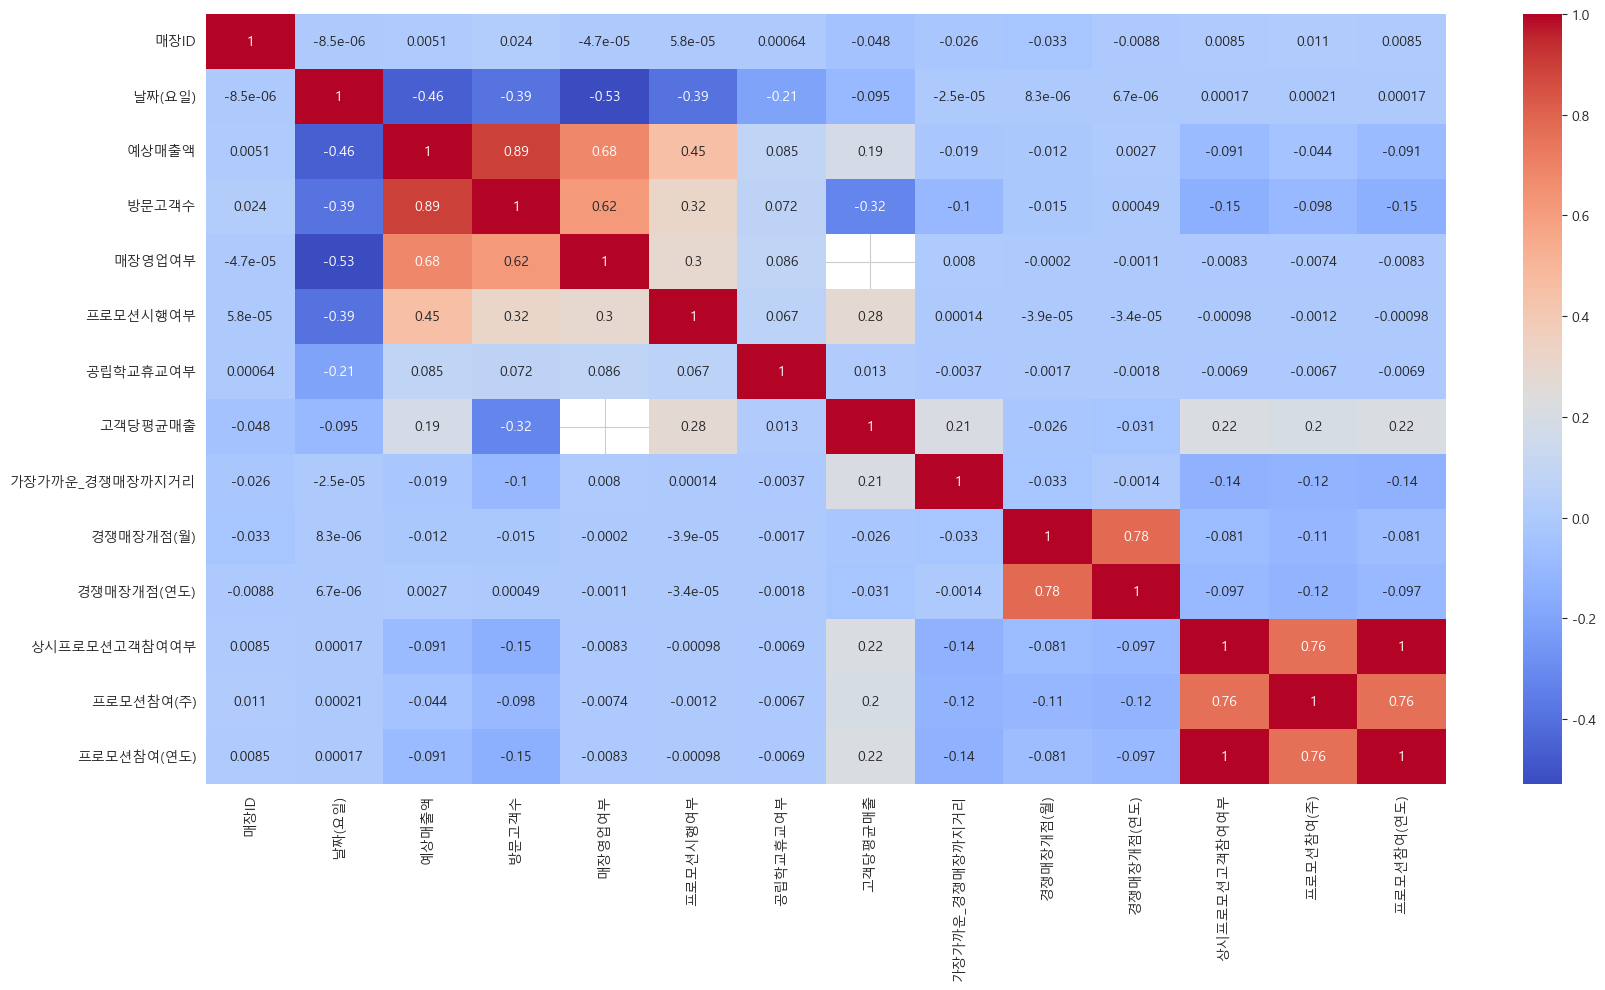

In [501]:
# 숫자형 컬럼만 사용하여 상관관계 분석(공휴일정보,매장유형,매장유형구분 제외)
numeric_df = train_store_joined.select_dtypes(include=['int64', 'float64'])

plt.figure(figsize=(20, 10))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.show()

(1)차 프로모션 시행여부 & 예상매출액의 ▲상관계수 0.45입니다. 프로모션을 하면 매출액이 증가하는 경향이 뚜렷합니다.


(1)차 프로모션 시행여부 & 방문고객수의 ▲상관계수 0.32입니다. 프로모션을 하면 방문 고객수가 증가합니다.


상시프로모션참여여부 & 고객당평균매출의 ▲상관계수 0.22입니다. 상시프로모션은 고객수를 늘리기보다 고객 1명당 구매액을 증가시키는 효과가 있을 가능성이 있습니다.
장기 구독형 할인이나 시즌 반복 할인 고려 가능합니다.


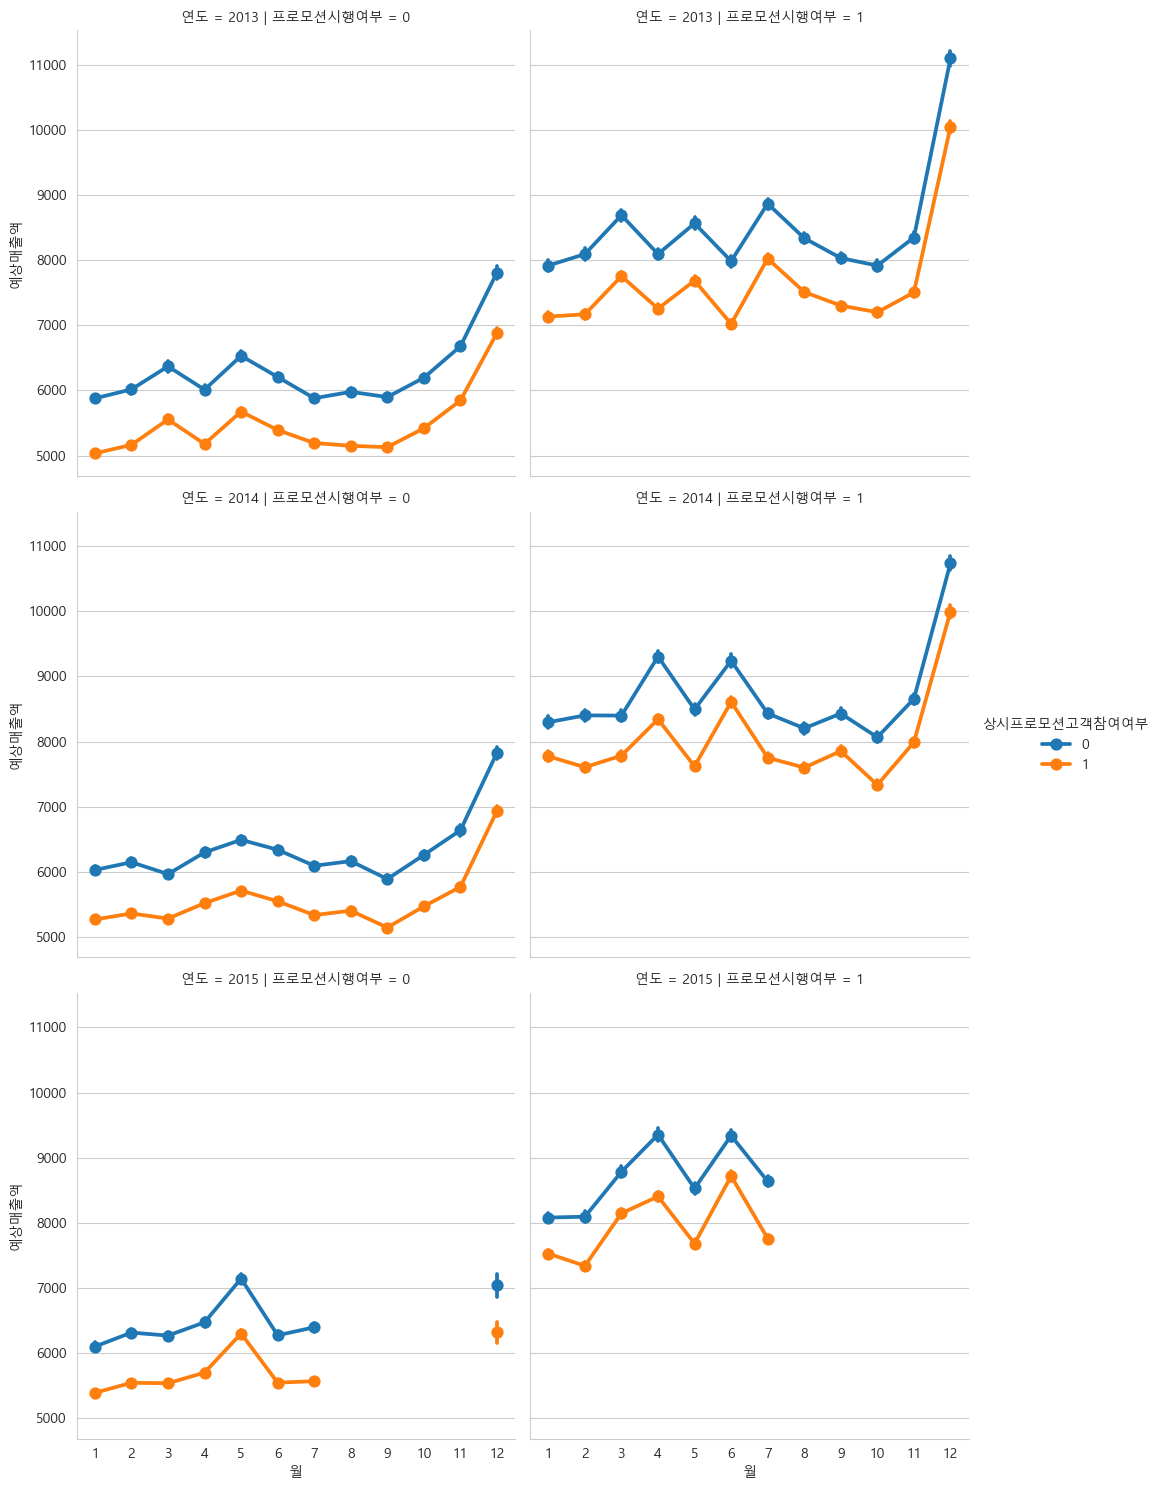

In [502]:
sns.catplot(data = train_store_joined_open, x='월', y='예상매출액',
              col ='프로모션시행여부', hue='상시프로모션고객참여여부', row='연도',kind='point')

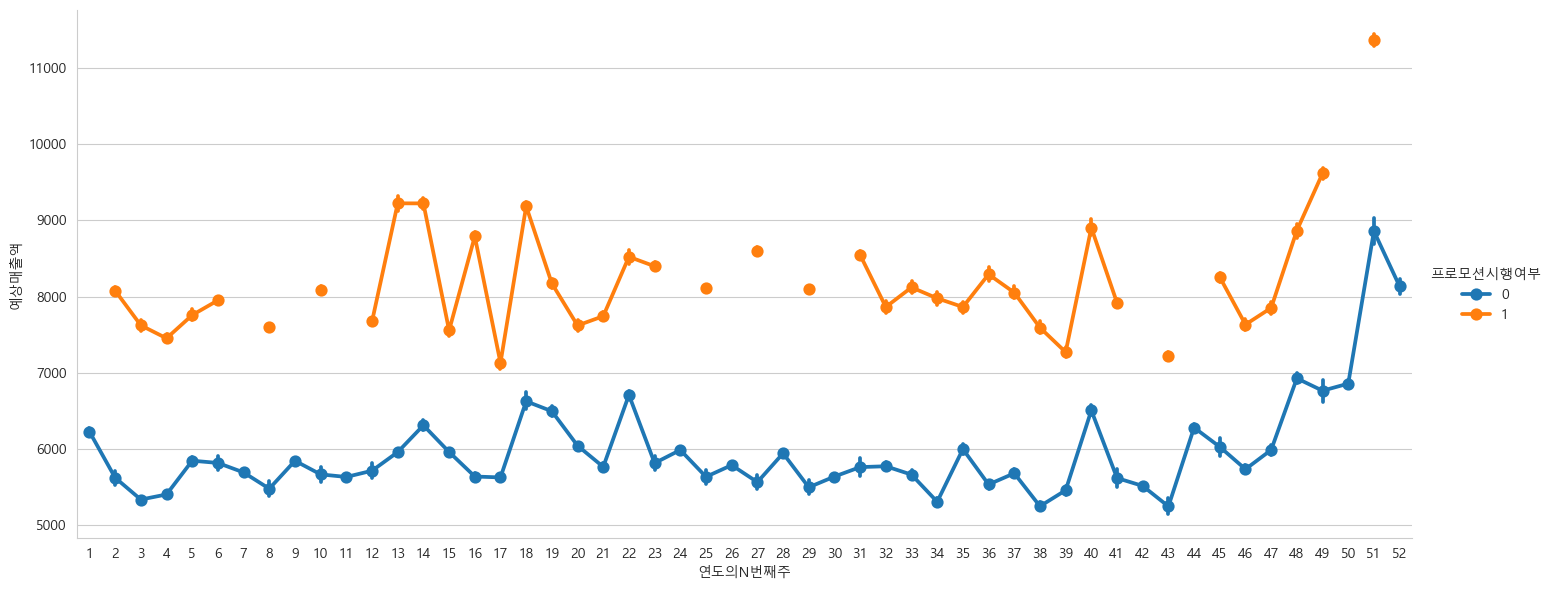

In [503]:
# 요일별 매출과 추세 분석

sns.catplot(data= train_store_joined_open, x='연도의N번째주', y="예상매출액",
              hue='프로모션시행여부', kind = 'point', height=6, aspect=2.4)

위 차트에서 0은 프로모션 없음 1은 프로모션이 시행됨을 의미합니다.
주말(토요일, 일요일)에는 프로모션이 제공되지 않습니다.

사람들은 주말에 생필품을 구매하러 많이 가기 때문에, 프로모션이 없어도 매출이 크게 증가하는 경향이 있습니다.

프로모션은 월요일에 가장 많이 진행되며, 그날 매출 역시 높게 나타납니다.
